Based on https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking/Chp_04.ipynb

Developed on colab

In [4]:
#pip install watermark

In [5]:
#pip install pymc3


In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from scipy.interpolate import griddata


In [7]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

4.1

In [8]:
# Random walk. Here are generated two indviduals (columns) walking 4 steps each of different length with a mean length of 0.
# 2 experiments 
rng.uniform(-1, 1, size=(4, 2))

array([[ 0.35926189,  0.45487329],
       [ 0.07306004, -0.42647258],
       [ 0.40048371,  0.4770558 ],
       [ 0.54494047,  0.45964114]])

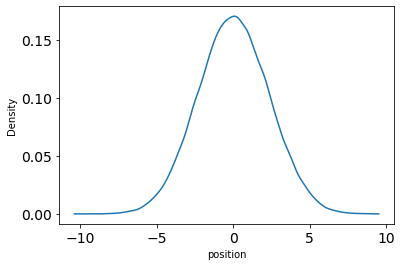

In [9]:
# Repeat for 10,000 individuals: does it look like the normal distribution
# ... this time?
pos = rng.uniform(-1, 1, size=(16, int(1e5))).sum(0)
az.plot_kde(pos)  # Kernal density estimation (need python 2.8+)
plt.xlabel("position")
plt.ylabel("Density");

Figure 4.2

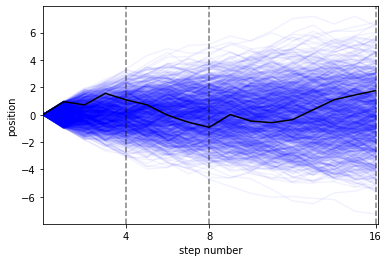

In [10]:
# Initialize a random generator.
step_rng = np.random.default_rng(1234)

steps = 16         # number of steps to take, each drawn from same distribution.
repetitions = 1000 # i.e. individuals

show_steps = [4, 8, 16]

# Set up a matrix, 17 rows (steps) for 1000 individuals (columns)
x = np.zeros([steps + 1, repetitions])

for i in range(x.shape[1]): # loop through the columns (indviduals)
    # For each, add a column of left (-1) or right (1) steps
    # These are added cumulatively.
    x[1:, i] = np.cumsum(step_rng.uniform(-1, 1, steps))

fig, ax = plt.subplots()
plt.plot(range(0, steps + 1), x[:, :],c="b" ,alpha=0.05)
plt.plot(range(0, steps + 1), x[:, 0], c="k")
for step in show_steps:
    plt.axvline(step, linestyle="--", c="k", alpha=0.5)

plt.xlabel("step number")
plt.ylabel("position")
ax.set_xticks(show_steps)
plt.xlim(0, step + 0.1)
plt.show()


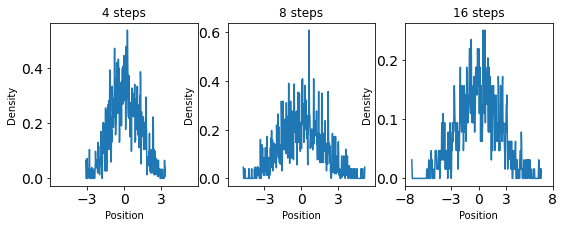

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True)

for step, ax in zip(show_steps, axs):
    az.plot_kde(x[step, :], bw=0.01, ax=ax)
    ax.set_title(f"{step} steps")
    ax.set_ylabel("Density")
    ax.set_xlabel("Position")
    ax.set_xlim(-6, 6)
    ax.set_xticks([-8, -3, 0, 3, 8])

*4.2, 4.3* Show the effect of multiplying random numbers together

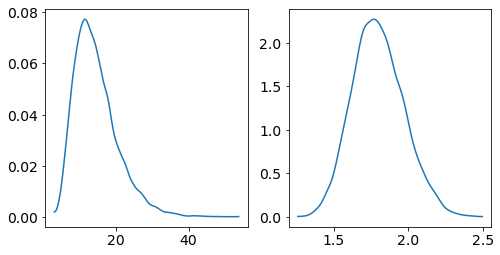

In [12]:
_, ax = plt.subplots (1, 2, figsize=(8,4) )
big= rng.uniform(1, 1.5, size=[12,10000]).prod(axis=0) 
small= rng.uniform(1, 1.1, size=[12,10000]).prod(axis=0) 

az.plot_kde ( big, ax = ax[0])
az.plot_kde ( small, ax = ax[1])


4.5 Even if you multiply large numbers together, the log will be close to normal

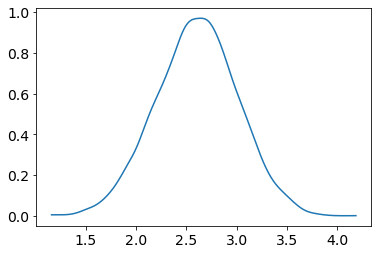

In [13]:
big_log = np.log ( rng.uniform(1, 1.5, size=[12,10000]).prod(axis=0)  ) 
az.plot_kde ( big_log)

4.6


In [14]:
w = 6; n = 9
p_grid = np.linspace ( 0, 1, 100 )
posterior = stats.binom.pmf ( k=w, n=n, p= p_grid ) * \
            stats.uniform.pdf ( p_grid, 0, 1  ) # list of ones
    
posterior = posterior / sum (posterior )
sum ( posterior)

0.9999999999999999

4.8

In [15]:
url = "https://raw.githubusercontent.com/steed360/Data-Analysis/main/b%20Statistical%20Rethinking/Data/Howell1.csv"
d = pd.read_csv(url,  sep=";", header=0)
d.head()


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


4.9

4.10

In [16]:
d2 = d[d.age >= 18]

4.11

In [17]:
d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [18]:
d2.height.mean()

154.5970926136364

Investigate possible priors (for height distribution)

4.12

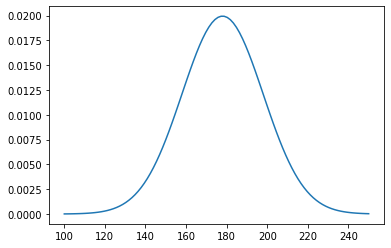

In [19]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

4.13

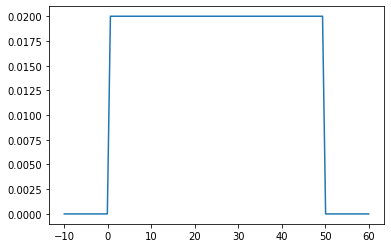

In [20]:
x = np.linspace ( -10, 60, 100)
plt.plot ( x, stats.uniform.pdf ( x, 0, 50 )  )

Predictive Simulation of Prior Information (guesses)
<BR>Needed to pick sensible priors

4.14

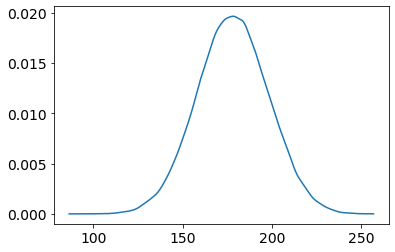

In [21]:
num_samples = int ( 1e5)
# Extract samples from the prior (hypothesized height)
# mu appears to mean the height 
sampled_mu = stats.norm.rvs (   178, 20, size = num_samples )
az.plot_kde ( sampled_mu)

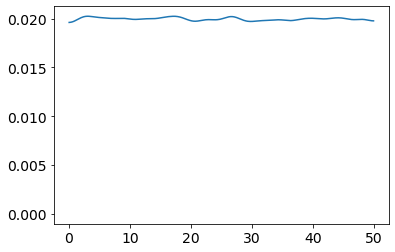

In [22]:
# Extract samples from the standard deviation sigma
sampled_sigma = stats.uniform.rvs (  0 , 50, size = num_samples )
az.plot_kde ( sampled_sigma ) 

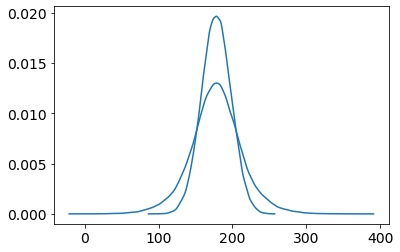

In [23]:
# Now sample from the contructed prior distribution using all of the uncertainty that 
# is in the mean distribution and the distribution of sigma
# It is a little wider than the prior height distribution with a single sigma value. 

#prior_h = stats.norm.rvs (   sampled_mu,sampled_sigma, size = num_samples )
prior_h = stats.norm.rvs(loc=sampled_mu, scale=sampled_sigma)

az.plot_kde ( prior_h)
az.plot_kde ( sampled_mu)

4.15 Using a more uninformative prior
<br> Sampled_mu is given a std of 100 instead of 20.
<br> Some of the sampled heights will come out negative.

([<matplotlib.axis.XTick at 0x7fba88c673a0>,
 <a list of 4 Text major ticklabel objects>)

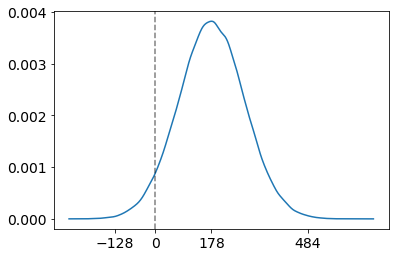

In [24]:
# sampled_mu = stats.norm.rvs (   178, 20, size = num_samples )
sampled_mu2 = stats.norm.rvs (   178, 100, size = num_samples )
prior_h2 = stats.norm.rvs(loc=sampled_mu2, scale=sampled_sigma)

az.plot_kde ( prior_h2)
plt.axvline(0 , linestyle="--", c="k", alpha=0.5)
plt.xticks ( [-128, 0, 178, 484])

In [25]:
# This is a clever way of doing a cartesian join on two lists.
# So it's a grid of mu and sigma combinations.
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

# Calculate the likelihood curve from the adult height data (!)
# All of the probabilities are added up.
likelihood = [
    # We are using the log normal distribution.
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

# Calculate the numerator.
post_prod = (
    likelihood + stats.norm.logpdf(post[:, 0], loc=178, scale=20) + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)

post_prob = np.exp(post_prod - max(post_prod))

In [26]:
print ( post_prob.shape)
print ( post.shape ) 

(8000,)
(8000, 2)


4.17 One way to visualize the distribution is wiht a contour plot.

Text(0, 0.5, 'signma')

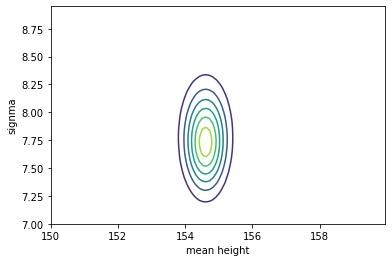

In [27]:

xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);

plt.xlabel ('mean height')
plt.ylabel ('signma')


4.18 Or with a heat map

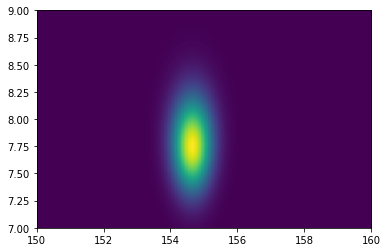

In [28]:
_, ax = plt.subplots()
ax.imshow(zi, origin="lower", extent=[150.0, 160.0, 7.0, 9.0], aspect="auto")
ax.grid(False)

Code 4.19 and 4.20 Sampling from the posterior

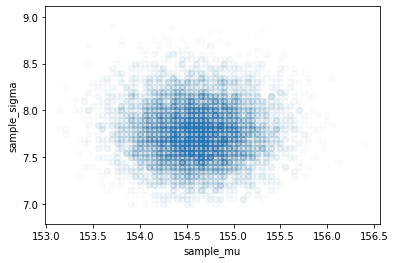

In [29]:
# Randomly generate row numbers from post_prob weighted according to the probabilities.
sample_rows = rng.choice(
    np.arange(len(post)), size=10000, replace=True, p=(post_prob / post_prob.sum())
)
# For the sampled rows grab parameter values of mu and sigma from the values grid
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

# Plot points
plt.plot(sample_mu, sample_sigma, "o", alpha=0.02)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

4.21 Using the samples from the posterior distribution, plot the mu and sigma values

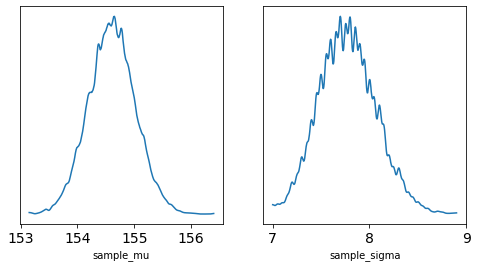

In [30]:
_, ax = plt.subplots (1, 2, figsize=(8,4) )
az.plot_kde ( sample_mu, ax=ax[0])
az.plot_kde ( sample_sigma, ax=ax[1] ) 
ax[0].set_xlabel("sample_mu")

ax[0].set_yticks([])

ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([])
ax[1].set_xticks(range (7,10))

4.22 Show the spread of values around the median

In [31]:
az.hdi(sample_mu,), az.hdi(sample_sigma)


(array([153.8 , 155.35]), array([7.25, 8.35]))

In [32]:
np.median ( sample_mu), np.median ( sample_sigma)

(154.6, 7.75)

4.23 Repeat the analysis for  a smaller sample. 

In [33]:
# Sample just 20 values from the dataset.
d3 = rng.choice(d2.height, 20)

# Now re-run the grid approximation. 
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i])) for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = rng.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

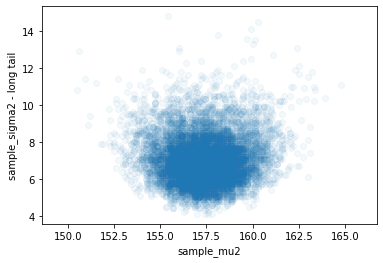

In [34]:
plt.plot(sample_mu2, sample_sigma2, "o", alpha=0.05)
plt.axis("equal")
plt.xlabel("sample_mu2")
plt.ylabel("sample_sigma2 - long tail")
plt.grid(False);

show the longer tail in variance

[]

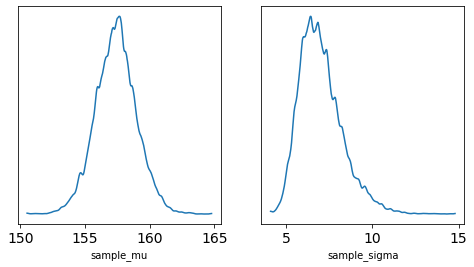

In [35]:
_, ax = plt.subplots (1, 2, figsize=(8,4) )
az.plot_kde ( sample_mu2, ax=ax[0])
az.plot_kde ( sample_sigma2, ax=ax[1] ) 
ax[0].set_xlabel("sample_mu")

ax[0].set_yticks([])

ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([])
#ax[1].set_xticks(range (7,10))

Linear Prediction

4.26

In [36]:
url = "https://raw.githubusercontent.com/steed360/Data-Analysis/main/b%20Statistical%20Rethinking/Data/Howell1.csv"
d = pd.read_csv(url,  sep=";", header=0)
d2 = d [ d.age >= 18 ]
d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


4.27

In [37]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    
    #trace_m4_1 = pm.sample(1000)
   

4.28

In [38]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000, return_inferencedata=True)


4.29


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba7b2e3d00>,
      dtype=object)

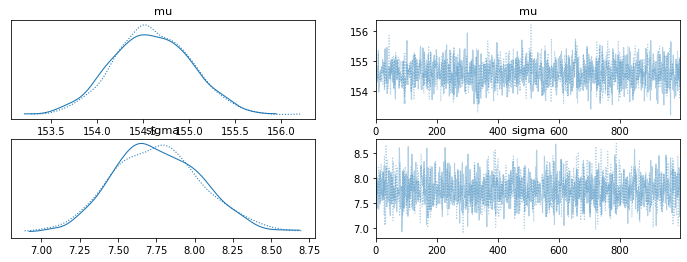

In [39]:
az.plot_trace(trace_4_1)

4.30 - Provide a start value

In [40]:
# We are not using quap so will skip this.

*4.31* Use a more influential prior ( range of height values )

In [41]:
with pm.Model() as m4_2:
    # Priors
    mu = pm.Normal("mu", mu=178, sd=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    # Calculate (or rather estimate) posterior distibution
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_m4_2 = pm.sample(1000, tune=1000,return_inferencedata=True ) 

The spread is much narrower.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fba7b3ff790>,
      dtype=object)

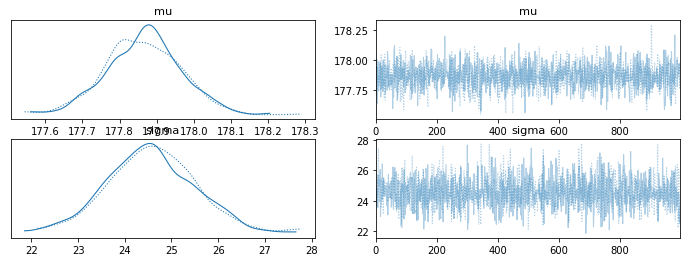

In [42]:
az.plot_trace(trace_m4_2)

4.32

In [43]:
trace_df = az.extract_dataset(trace_4_1).to_dataframe()
trace_df.cov()

,mu,sigma,chain,draw
mu,0.174704,0.004182,0.005233,-1.472385
sigma,0.004182,0.086272,-0.000743,-0.606948
chain,0.005233,-0.000743,0.250125,0.000000
draw,-1.472385,-0.606948,0.000000,83374.937469


4.33

In [44]:
np.diag(trace_df)

array([154.959682  ,   7.51376153,   0.        ,   3.        ])

In [45]:
trace_df.corr()

,mu,sigma,chain,draw
mu,1.000000,0.034068,2.503228e-02,-1.219978e-02
sigma,0.034068,1.000000,-5.057196e-03,-7.156468e-03
chain,0.025032,-0.005057,1.000000e+00,-9.913508e-16
draw,-0.012200,-0.007156,-9.913508e-16,1.000000e+00


4.34

In [46]:
trace_df.head()

mu     sigma  chain  draw
chain draw                                   
0     0     154.959682  8.227169      0     0
      1     154.734825  7.513762      0     1
      2     154.655301  7.961685      0     2
      3     154.684229  7.393112      0     3
      4     154.684229  7.393112      0     4

In [47]:
trace_4_1.posterior["sigma"][0][:10]

<xarray.DataArray 'sigma' (draw: 10)>
array([8.22716872, 7.51376153, 7.96168539, 7.39311229, 7.39311229,
       8.00682856, 7.88525059, 7.96249361, 7.87782259, 7.37580068])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

Code 4.35

In [48]:
az.summary(trace_4_1, round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu,154.60,0.42,153.87,155.43
sigma,7.76,0.29,7.23,8.31


4.36

In [49]:
trace_df.mean() 

mu       154.595891
sigma      7.761278
chain      0.500000
draw     499.500000
dtype: float64

In [50]:
# ???
#stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=2)


4.37

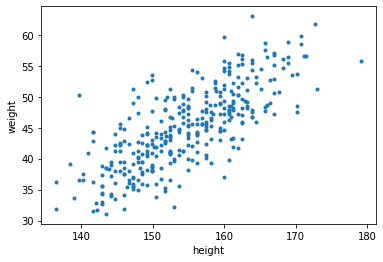

In [51]:
plt.plot(d2.height, d2.weight, ".")
plt.xlabel("height")
plt.ylabel("weight");

4.38

In [52]:

height_rng = np.random.default_rng(2971)

# Sample 100 values  from the prior distributions.
N = 100 
a = stats.norm.rvs(178, 20, N)   
b = stats.norm.rvs(0, 10, N)# # note that this variable is distributed into negative numbers, this can be repaired with logNorm (see below)

Code 4.39 and 4.40  Plug the priors into the model and see what happens to the regresion line.

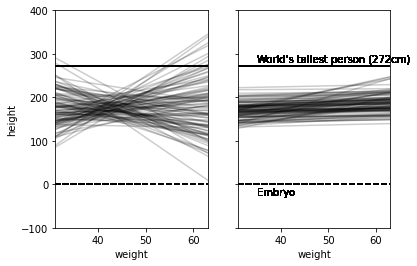

In [53]:
_, ax = plt.subplots(1, 2, sharey=True)
xbar = d2.weight.mean()

x = np.linspace(d2.weight.min(), d2.weight.max(), 100)

for i in range(N):
    ax[0].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")

# Redo the beta distribution, force it to be positive.
b2 = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(a[i] + b2[i] * (x - xbar), "k", alpha=0.2)
    ax[1].set_xlim(d2.weight.min(), d2.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c="k", ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_xlabel("weight")
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo");

4.42 Fitting the model

In [54]:
xbar = d2.weight.mean()

with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    
    trace_4_3 = pm.sample(1000, tune=1000, return_inferencedata=True)


And fit a non-linear variant

In [55]:
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Normal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + np.exp(b) * (d2.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3b = pm.sample(1000, tune=1000 , return_inferencedata=True)

Code 4.44

In [56]:
az.summary(trace_4_3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,154.600,0.265,154.102,155.091
b,0.906,0.043,0.830,0.991
sigma,5.106,0.191,4.743,5.446


Code 4.45

In [57]:
trace_4_3_df = trace_4_3.posterior.to_dataframe()
trace_4_3_df.cov().round(3)

,a,b,sigma
a,0.070,0.000,-0.003
b,0.000,0.002,-0.000
sigma,-0.003,-0.000,0.037


4.46

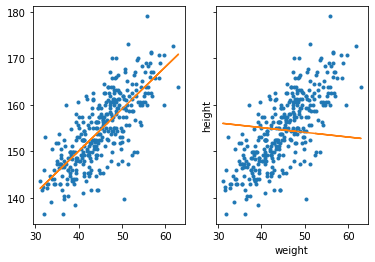

In [58]:
_, ax = plt.subplots(1, 2, sharey=True)

plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

ax[0].plot(d2.weight, d2.height, ".")
ax[0].plot(
    d2.weight,
    trace_4_3.posterior["a"].mean().item(0)
    + trace_4_3.posterior["b"].mean().item(0) * (d2.weight - xbar)
)

# The non linear model has not worked well!
ax[1].plot(d2.weight, d2.height, ".")
ax[1].plot(
    d2.weight,
    trace_4_3b.posterior["a"].mean().item(0)
    + trace_4_3b.posterior["b"].mean().item(0) * (d2.weight - xbar)
)

Code 4.47

In [59]:
trace_4_3_df.head(5)

a         b     sigma
chain draw                                
0     0     154.744888  0.822239  5.310116
      1     154.746082  0.847154  4.745427
      2     154.609757  0.878516  5.592730
      3     155.072601  0.986877  5.361825
      4     155.042767  0.977524  5.232596

4.48 - show how the  model fits just 10 points. Pick the points randomly from the data file

*   List item
*   List item



In [145]:
import random  as r
index = r.choices ( range ( 0, d2.shape[0]), k=10 )

N = [10, 50, 150, 352][0]
#dN = d2[:N]
dN = d2.iloc[ index]

with pm.Model() as m_N:
    a = pm.Normal("a", mu=178, sigma=100)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (dN.weight.values - xbar)
    # This is an alternative way to write it - I'm not sure of the difference.
    #mu = pm.Deterministic("mu", a + b * (dN.weight.values - dN.weight.mean()))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=dN.height.values)
    chain_N = pm.sample(1000, tune=2000,return_inferencedata=True )

trace_N = az.extract_dataset(chain_N ) 


4.49 Plot all lines from a model with 10 points
In the book the first ten points are used but here they are selected randomly, which sometimes gives an odd looking model

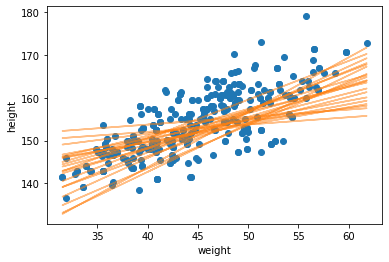

In [212]:
plt.plot(dN.weight, dN.height, "C0o")

# random pairs from the posterior distribution.
idxs = height_rng.integers(nb_samples, size=20)
for idx in idxs:
    plt.plot(
        dN.weight,
        trace_N["a"].item(idx) + trace_N["b"].item(idx) * (dN.weight - dN.weight.mean()),
        "C1-",
        alpha=0.5,
    )
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

Run 4 models, with different numbers of rows of data ( 10 rows, 50 rows, 150 rows )

In [ ]:
import random  as r
N = [10, 50, 150, 352]

data = []
traces = []

for n in N:

    lstIndex = r.choices ( range ( 0, d2.shape[0]), k= n )
    dN = d2.iloc[ lstIndex]

    with pm.Model() as m_N:

        a = pm.Normal("a", mu=178, sigma=100)
        b = pm.Lognormal("b", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", 0, 50)
        mu = a + b * (dN.weight.values - xbar)

        # The deterministic way means that values for mu can be extracted directly from 
        # the posterior distribution, so that is a convenience.
        #mu = pm.Deterministic("mu", a + b * (dN.weight.values - dN.weight.mean()))

        # Here's the estimation part.
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=dN.height.values)
        
        traces.append(pm.sample(1000, tune=1000, progressbar=False, return_inferencedata=True))

        data.append(dN)


Now draw 10 samples from each model and plot them to see how close they are

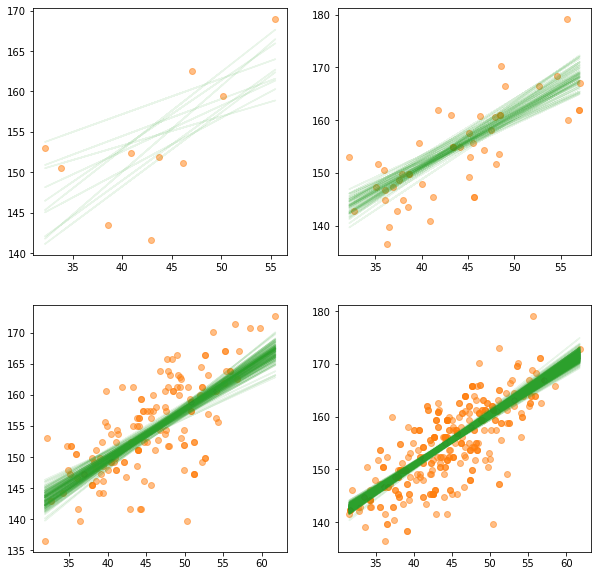

In [214]:

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Plot definitions (row, column)
cords = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i in range(len(data)):  # loop through the (4) models

    # Randomly get indexes ( to sample from both data and posterior ).
    idxs = height_rng.integers(nb_samples, size=N[i])

    # For readability
    lstX    = data[i].weight  
    lstY    = data[i].height

    extractedTrace =  az.extract_dataset( traces[i] ) 

    # plot the points
    ax[cords[i]].plot(lstX, lstY, "C1o", alpha=0.5)

    nb_samples = 2000 #traces[i].sizes["sample"]  # Number of samples we can selecte from 
    idxs = height_rng.integers(nb_samples, size=N[i]) # the sample indexes we are going to plot

    for idx in idxs:
      lstYHat = extractedTrace["a"][idx].values + extractedTrace["b"][idx].values * ( data[i].weight - data[i].weight.mean())
      ax[cords[i]].plot(lstX, lstYHat, "C2-", alpha= 0.1)


4.50 4.51 Extract the height(s) for someone who is 50 kg above the mean weight.



In [237]:
50 - d2.weight.mean() # 6
d2.weight.mean() # 44

44.99048551988636

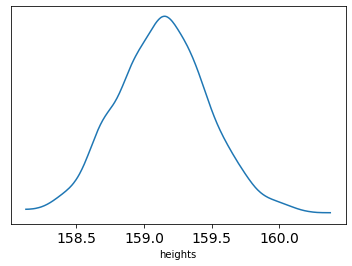

In [241]:
data_4_3 = az.extract_dataset(trace_4_3)
mu_at_50 = data_4_3["a"] + data_4_3["b"] * (50 - d2.weight.mean())  # weigt at 50 above the mean.
az.plot_kde(mu_at_50.values)
plt.xlabel("heights")
plt.yticks([]);

4.52 - show a credible interval for this estimate

In [242]:
az.hdi(mu_at_50.values, hdi_prod=0.89)


array([158.51253708, 159.79547069])

4.53

In [160]:
#%load_ext watermark
#%watermark -n -u -v -iv -w -p aesara,aeppl,xarray